### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import uuid
#add whatever you need

### Architecture

In [2]:
# ResNeXt Block
class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cardinality=8, bottleneck_width=4, stride=1):
        super(ResNeXtBlock, self).__init__()
        # Calculate intermediate channels (bottleneck)
        inter_channels = cardinality * bottleneck_width

        # 1x1 convolution to reduce dimensionality
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inter_channels)

        # 3x3 group convolution with cardinality
        self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, stride=stride,
                              padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_channels)

        # 1x1 convolution to restore dimensionality
        self.conv3 = nn.Conv2d(inter_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        # Add shortcut
        out += self.shortcut(identity)
        out = F.relu(out)
        return out
# ResNeXt Network
class ResNeXt(nn.Module):
    def __init__(self, num_classes=100, cardinality=8, bottleneck_width=4):
        super(ResNeXt, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Three stages
        self.stage1 = self._make_stage(64, 2, cardinality, bottleneck_width, stride=1)
        self.stage2 = self._make_stage(128, 2, cardinality, bottleneck_width, stride=2)
        self.stage3 = self._make_stage(256, 2, cardinality, bottleneck_width, stride=2)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _make_stage(self, out_channels, num_blocks, cardinality, bottleneck_width, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(ResNeXtBlock(self.in_channels, out_channels, cardinality, bottleneck_width, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Preprocess and DataLoaders

In [ ]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create validation split
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
val_size = int(0.1 * num_train)  # 10% for validation
train_idx, val_idx = indices[val_size:], indices[:val_size]

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# Data loaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print(f'Training samples: {len(train_subset)}')
print(f'Validation samples: {len(val_subset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Training samples: 45000
Validation samples: 5000
Test samples: 10000


### Model Initialization

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNeXt(num_classes=100).to(device)


In [5]:
#keep this cell
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)


106826


### Training

In [6]:
# Training function
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
def train_model(model, train_loader, val_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_acc = 0.0
    best_model_path = 'best_resnext.pth'
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        # Update learning rate
        scheduler.step()

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs, best_model_path

# Train the model
train_losses, train_accs, val_losses, val_accs, best_model_path = train_model(model, train_loader, val_loader)

Epoch 1/50: 100%|██████████| 352/352 [00:24<00:00, 14.50it/s]


Epoch 1: Train Loss: 1.8676, Train Acc: 30.47%, Val Loss: 1.5613, Val Acc: 41.60%


Epoch 2/50: 100%|██████████| 352/352 [00:22<00:00, 15.88it/s]


Epoch 2: Train Loss: 1.4809, Train Acc: 44.56%, Val Loss: 1.5634, Val Acc: 43.56%


Epoch 3/50: 100%|██████████| 352/352 [00:23<00:00, 15.30it/s]


Epoch 3: Train Loss: 1.3182, Train Acc: 51.52%, Val Loss: 1.3541, Val Acc: 50.96%


Epoch 4/50: 100%|██████████| 352/352 [00:22<00:00, 15.37it/s]


Epoch 4: Train Loss: 1.2152, Train Acc: 56.06%, Val Loss: 1.3093, Val Acc: 52.42%


Epoch 5/50: 100%|██████████| 352/352 [00:24<00:00, 14.61it/s]


Epoch 5: Train Loss: 1.1340, Train Acc: 59.32%, Val Loss: 1.3340, Val Acc: 54.58%


Epoch 6/50: 100%|██████████| 352/352 [00:22<00:00, 15.37it/s]


Epoch 6: Train Loss: 1.0810, Train Acc: 61.53%, Val Loss: 1.2898, Val Acc: 54.20%


Epoch 7/50: 100%|██████████| 352/352 [00:22<00:00, 15.45it/s]


Epoch 7: Train Loss: 1.0447, Train Acc: 62.78%, Val Loss: 1.1602, Val Acc: 59.42%


Epoch 8/50: 100%|██████████| 352/352 [00:22<00:00, 15.65it/s]


Epoch 8: Train Loss: 1.0096, Train Acc: 64.23%, Val Loss: 1.2715, Val Acc: 55.14%


Epoch 9/50: 100%|██████████| 352/352 [00:22<00:00, 15.86it/s]


Epoch 9: Train Loss: 0.9847, Train Acc: 65.17%, Val Loss: 1.0932, Val Acc: 61.28%


Epoch 10/50: 100%|██████████| 352/352 [00:22<00:00, 15.82it/s]


Epoch 10: Train Loss: 0.9600, Train Acc: 66.15%, Val Loss: 1.1839, Val Acc: 59.34%


Epoch 11/50: 100%|██████████| 352/352 [00:21<00:00, 16.07it/s]


Epoch 11: Train Loss: 0.9437, Train Acc: 66.98%, Val Loss: 1.1059, Val Acc: 59.76%


Epoch 12/50: 100%|██████████| 352/352 [00:22<00:00, 15.89it/s]


Epoch 12: Train Loss: 0.9155, Train Acc: 67.94%, Val Loss: 1.2881, Val Acc: 56.80%


Epoch 13/50: 100%|██████████| 352/352 [00:22<00:00, 15.93it/s]


Epoch 13: Train Loss: 0.8942, Train Acc: 68.66%, Val Loss: 1.2013, Val Acc: 58.66%


Epoch 14/50: 100%|██████████| 352/352 [00:22<00:00, 15.83it/s]


Epoch 14: Train Loss: 0.8755, Train Acc: 69.51%, Val Loss: 1.3684, Val Acc: 55.96%


Epoch 15/50: 100%|██████████| 352/352 [00:22<00:00, 15.88it/s]


Epoch 15: Train Loss: 0.8525, Train Acc: 70.18%, Val Loss: 0.8977, Val Acc: 67.38%


Epoch 16/50: 100%|██████████| 352/352 [00:23<00:00, 15.22it/s]


Epoch 16: Train Loss: 0.8374, Train Acc: 70.99%, Val Loss: 0.8146, Val Acc: 72.60%


Epoch 17/50: 100%|██████████| 352/352 [00:21<00:00, 16.09it/s]


Epoch 17: Train Loss: 0.8137, Train Acc: 71.86%, Val Loss: 1.0861, Val Acc: 63.06%


Epoch 18/50: 100%|██████████| 352/352 [00:21<00:00, 16.25it/s]


Epoch 18: Train Loss: 0.7974, Train Acc: 72.49%, Val Loss: 0.8981, Val Acc: 68.52%


Epoch 19/50: 100%|██████████| 352/352 [00:22<00:00, 15.46it/s]


Epoch 19: Train Loss: 0.7763, Train Acc: 73.05%, Val Loss: 0.8439, Val Acc: 69.64%


Epoch 20/50: 100%|██████████| 352/352 [00:22<00:00, 15.48it/s]


Epoch 20: Train Loss: 0.7593, Train Acc: 73.78%, Val Loss: 0.9235, Val Acc: 67.50%


Epoch 21/50: 100%|██████████| 352/352 [00:22<00:00, 15.36it/s]


Epoch 21: Train Loss: 0.7462, Train Acc: 74.30%, Val Loss: 0.8567, Val Acc: 69.50%


Epoch 22/50: 100%|██████████| 352/352 [00:22<00:00, 15.53it/s]


Epoch 22: Train Loss: 0.7386, Train Acc: 74.49%, Val Loss: 0.8166, Val Acc: 71.44%


Epoch 23/50: 100%|██████████| 352/352 [00:22<00:00, 15.48it/s]


Epoch 23: Train Loss: 0.7293, Train Acc: 74.51%, Val Loss: 0.8099, Val Acc: 71.06%


Epoch 24/50: 100%|██████████| 352/352 [00:22<00:00, 15.70it/s]


Epoch 24: Train Loss: 0.7072, Train Acc: 75.45%, Val Loss: 0.9527, Val Acc: 68.14%


Epoch 25/50: 100%|██████████| 352/352 [00:22<00:00, 15.48it/s]


Epoch 25: Train Loss: 0.6935, Train Acc: 76.25%, Val Loss: 0.9164, Val Acc: 69.14%


Epoch 26/50: 100%|██████████| 352/352 [00:22<00:00, 15.49it/s]


Epoch 26: Train Loss: 0.6775, Train Acc: 76.48%, Val Loss: 0.8854, Val Acc: 70.98%


Epoch 27/50: 100%|██████████| 352/352 [00:23<00:00, 15.29it/s]


Epoch 27: Train Loss: 0.6730, Train Acc: 76.79%, Val Loss: 0.6647, Val Acc: 76.72%


Epoch 28/50: 100%|██████████| 352/352 [00:22<00:00, 15.71it/s]


Epoch 28: Train Loss: 0.6572, Train Acc: 77.31%, Val Loss: 0.8196, Val Acc: 73.30%


Epoch 29/50: 100%|██████████| 352/352 [00:22<00:00, 15.59it/s]


Epoch 29: Train Loss: 0.6403, Train Acc: 78.07%, Val Loss: 0.6341, Val Acc: 77.96%


Epoch 30/50: 100%|██████████| 352/352 [00:22<00:00, 15.61it/s]


Epoch 30: Train Loss: 0.6288, Train Acc: 78.45%, Val Loss: 0.7000, Val Acc: 75.58%


Epoch 31/50: 100%|██████████| 352/352 [00:22<00:00, 15.79it/s]


Epoch 31: Train Loss: 0.6128, Train Acc: 78.88%, Val Loss: 0.6653, Val Acc: 76.02%


Epoch 32/50: 100%|██████████| 352/352 [00:22<00:00, 15.65it/s]


Epoch 32: Train Loss: 0.5992, Train Acc: 79.58%, Val Loss: 0.5923, Val Acc: 79.26%


Epoch 33/50: 100%|██████████| 352/352 [00:21<00:00, 16.19it/s]


Epoch 33: Train Loss: 0.5831, Train Acc: 80.10%, Val Loss: 0.6171, Val Acc: 78.90%


Epoch 34/50: 100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Epoch 34: Train Loss: 0.5662, Train Acc: 80.75%, Val Loss: 0.6512, Val Acc: 77.18%


Epoch 35/50: 100%|██████████| 352/352 [00:21<00:00, 16.03it/s]


Epoch 35: Train Loss: 0.5509, Train Acc: 81.06%, Val Loss: 0.5602, Val Acc: 80.96%


Epoch 36/50: 100%|██████████| 352/352 [00:21<00:00, 16.04it/s]


Epoch 36: Train Loss: 0.5388, Train Acc: 81.40%, Val Loss: 0.6298, Val Acc: 79.52%


Epoch 37/50: 100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Epoch 37: Train Loss: 0.5214, Train Acc: 82.27%, Val Loss: 0.5841, Val Acc: 79.80%


Epoch 38/50: 100%|██████████| 352/352 [00:22<00:00, 15.96it/s]


Epoch 38: Train Loss: 0.5070, Train Acc: 82.66%, Val Loss: 0.5621, Val Acc: 81.08%


Epoch 39/50: 100%|██████████| 352/352 [00:23<00:00, 15.03it/s]


Epoch 39: Train Loss: 0.4888, Train Acc: 83.24%, Val Loss: 0.5037, Val Acc: 83.08%


Epoch 40/50: 100%|██████████| 352/352 [00:22<00:00, 15.85it/s]


Epoch 40: Train Loss: 0.4719, Train Acc: 83.98%, Val Loss: 0.5176, Val Acc: 82.26%


Epoch 41/50: 100%|██████████| 352/352 [00:22<00:00, 15.81it/s]


Epoch 41: Train Loss: 0.4533, Train Acc: 84.41%, Val Loss: 0.4815, Val Acc: 83.60%


Epoch 42/50: 100%|██████████| 352/352 [00:22<00:00, 15.54it/s]


Epoch 42: Train Loss: 0.4409, Train Acc: 84.99%, Val Loss: 0.4558, Val Acc: 84.40%


Epoch 43/50: 100%|██████████| 352/352 [00:22<00:00, 15.65it/s]


Epoch 43: Train Loss: 0.4246, Train Acc: 85.42%, Val Loss: 0.4464, Val Acc: 85.14%


Epoch 44/50: 100%|██████████| 352/352 [00:22<00:00, 15.57it/s]


Epoch 44: Train Loss: 0.4107, Train Acc: 86.00%, Val Loss: 0.4207, Val Acc: 85.38%


Epoch 45/50: 100%|██████████| 352/352 [00:22<00:00, 15.56it/s]


Epoch 45: Train Loss: 0.3965, Train Acc: 86.45%, Val Loss: 0.4125, Val Acc: 86.08%


Epoch 46/50: 100%|██████████| 352/352 [00:22<00:00, 15.72it/s]


Epoch 46: Train Loss: 0.3794, Train Acc: 87.02%, Val Loss: 0.3947, Val Acc: 86.82%


Epoch 47/50: 100%|██████████| 352/352 [00:22<00:00, 15.81it/s]


Epoch 47: Train Loss: 0.3743, Train Acc: 87.30%, Val Loss: 0.3954, Val Acc: 86.34%


Epoch 48/50: 100%|██████████| 352/352 [00:21<00:00, 16.19it/s]


Epoch 48: Train Loss: 0.3659, Train Acc: 87.52%, Val Loss: 0.3855, Val Acc: 86.92%


Epoch 49/50: 100%|██████████| 352/352 [00:21<00:00, 16.46it/s]


Epoch 49: Train Loss: 0.3632, Train Acc: 87.74%, Val Loss: 0.3870, Val Acc: 87.16%


Epoch 50/50: 100%|██████████| 352/352 [00:22<00:00, 15.69it/s]


Epoch 50: Train Loss: 0.3606, Train Acc: 87.70%, Val Loss: 0.3865, Val Acc: 86.96%


### Test Results

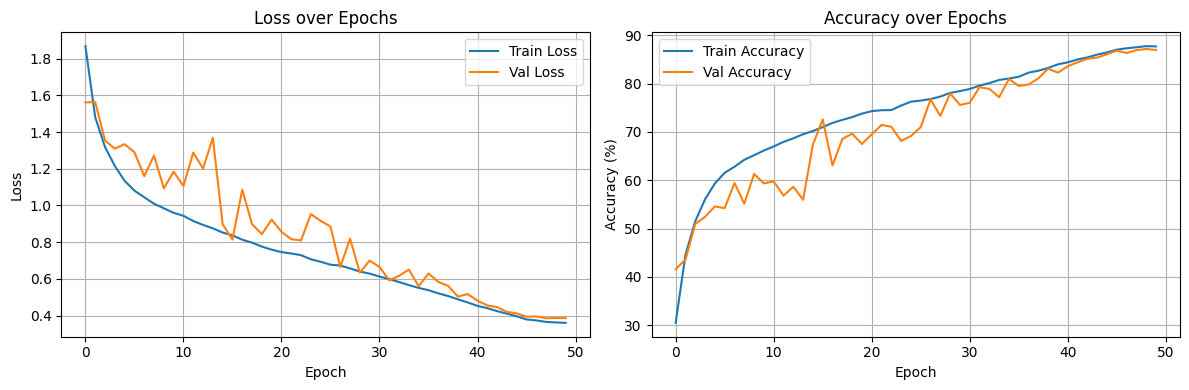

In [9]:
# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [10]:
# Evaluate on test set
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 33.89it/s]

Test Accuracy: 87.79%
